# Gene-Level Clustering Analysis of Time-Resolved Fitness Data

## Overview
This notebook performs comprehensive clustering analysis on genome-wide gene disruption time-resolved fitness data. For each gene, we have five fitness LFC (Log Fold Change) values across five time points (t0-t4), along with sigmoid curve fitting parameters.

**Data Interpretation:**
- LFC ≈ 0: No fitness effect from gene disruption
- LFC > 0: Gene disruption causes growth defects
- LFC < 0: Gene disruption improves cell growth

**Analysis Goals:**
1. Cluster genes based on different feature sets (raw values, fitted values, curve parameters)
2. Compare multiple clustering algorithms
3. Determine optimal cluster numbers using statistical metrics
4. Visualize depletion curves for each cluster

**Author:** [Your Name]  
**Date:** [Current Date]


In [3]:
#!/usr/bin/env python3
"""
Gene-level clustering analysis setup and imports.
"""

# Standard library imports
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

# Machine learning
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Color palette from cursor rules
COLORS = {
    'purple': '#962955',
    'green': '#7fb775', 
    'blue': '#6479cc',
    'gold': '#ad933c',
    'bright_blue': '#26b1fd',
    'medium_purple': '#8c397b',
    'light_purple': '#b684d5',
    'pink_purple': '#eb85c0',
    'yellow_green': '#9ab25d',
    'teal': '#008a77'
}

# Figure settings
FIGURE_DPI = 300
FIGURE_SIZES = {
    'small': (4, 3),
    'medium': (6, 4.5),
    'large': (8, 6),
    'wide': (10, 4)
}

print("✓ All imports successful")
print("✓ Logging configured")
print("✓ Plotting settings applied")
logger.info("Setup complete")


2025-06-12 13:09:03,053 - INFO - Setup complete


✓ All imports successful
✓ Logging configured
✓ Plotting settings applied


## 1. Data Loading and Exploration

In [4]:
def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """
    Load the gene-level statistics data and perform initial exploration.
    
    Args:
        file_path: Path to the CSV file containing gene statistics
        
    Returns:
        DataFrame with loaded data
    """
    logger.info(f"Loading data from {file_path}")
    
    # Load data
    data_path = Path(file_path)
    if not data_path.exists():
        raise FileNotFoundError(f"Data file not found: {file_path}")
    
    df = pd.read_csv(data_path)
    
    # Basic data exploration
    logger.info(f"Data shape: {df.shape}")
    logger.info(f"Columns: {list(df.columns)}")
    
    # Check for missing values
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        logger.warning(f"Missing values found:\n{missing_summary[missing_summary > 0]}")
    
    # Basic statistics
    print("\n=== DATA SUMMARY ===")
    print(f"Total genes: {len(df)}")
    print(f"Successful fits: {(df['Status'] == 'Success').sum()}")
    print(f"Failed fits: {(df['Status'] != 'Success').sum()}")
    
    # Essentiality distribution
    if 'DeletionLibrary_essentiality' in df.columns:
        essentiality_counts = df['DeletionLibrary_essentiality'].value_counts()
        print(f"\nEssentiality distribution:")
        for category, count in essentiality_counts.items():
            print(f"  {category}: {count} ({count/len(df)*100:.1f}%)")
    
    return df

# Load the data
data_file = "../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.csv"
df = load_and_explore_data(data_file)

output_folder = Path("../../results/HD_DIT_HAP/20_gene_level_clustering")
output_folder.mkdir(parents=True, exist_ok=True)


2025-06-12 13:09:03,064 - INFO - Loading data from ../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.csv
2025-06-12 13:09:03,083 - INFO - Data shape: (4496, 27)
2025-06-12 13:09:03,084 - INFO - Columns: ['Systematic ID', 'Name', 'FYPOviability', 'DeletionLibrary_essentiality', 'time_points', 'Status', 'A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE', 't0', 't1', 't2', 't3', 't4', 't0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted', 't0_residual', 't1_residual', 't2_residual', 't3_residual', 't4_residual']



=== DATA SUMMARY ===
Total genes: 4496
Successful fits: 4496
Failed fits: 0

Essentiality distribution:
  V: 3161 (70.3%)
  E: 1141 (25.4%)
  Not_determined: 194 (4.3%)


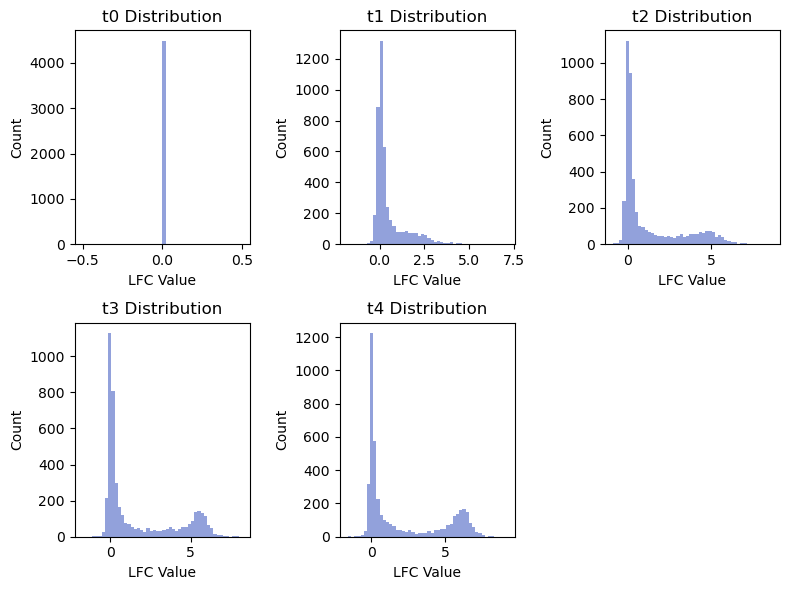

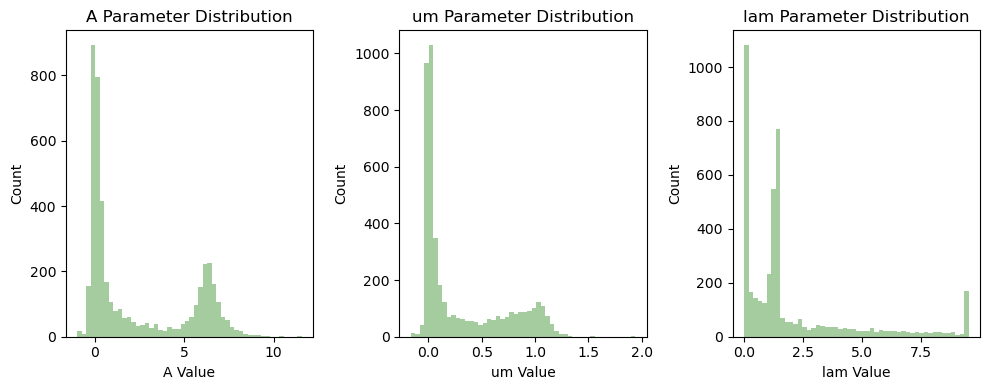

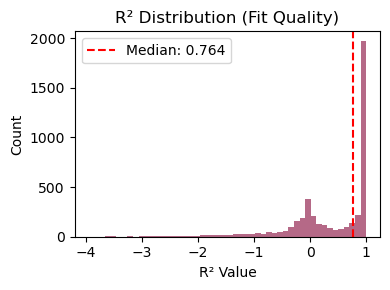

In [5]:
def visualize_data_distributions(df: pd.DataFrame) -> None:
    """
    Create visualizations to understand data distributions.
    
    Args:
        df: Input DataFrame with gene statistics
    """
    fig, axes = plt.subplots(2, 3, figsize=FIGURE_SIZES['large'])
    
    # Raw fitness values distribution
    raw_cols = ['t0', 't1', 't2', 't3', 't4']
    for i, col in enumerate(raw_cols):
        if i < 5:
            ax = axes[0, i] if i < 3 else axes[1, i-3]
            ax.hist(df[col], bins=50, alpha=0.7, color=COLORS['blue'])
            ax.set_title(f'{col} Distribution')
            ax.set_xlabel('LFC Value')
            ax.set_ylabel('Count')
    
    # Remove empty subplot
    if len(raw_cols) < 6:
        fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Curve fitting parameters
    fig, axes = plt.subplots(1, 3, figsize=FIGURE_SIZES['wide'])
    
    param_cols = ['A', 'um', 'lam']
    for i, col in enumerate(param_cols):
        axes[i].hist(df[col], bins=50, alpha=0.7, color=COLORS['green'])
        axes[i].set_title(f'{col} Parameter Distribution')
        axes[i].set_xlabel(f'{col} Value')
        axes[i].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # R² distribution
    plt.figure(figsize=FIGURE_SIZES['small'])
    plt.hist(df['R2'], bins=50, alpha=0.7, color=COLORS['purple'])
    plt.title('R² Distribution (Fit Quality)')
    plt.xlabel('R² Value')
    plt.ylabel('Count')
    plt.axvline(df['R2'].median(), color='red', linestyle='--', 
                label=f'Median: {df["R2"].median():.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize data distributions
visualize_data_distributions(df)


## 2. Data Preparation for Clustering

In [6]:
def prepare_clustering_datasets(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """
    Prepare different feature sets for clustering analysis.
    
    Args:
        df: Input DataFrame with gene statistics
        
    Returns:
        Dictionary containing different feature matrices
    """
    logger.info("Preparing clustering datasets")
    
    # Filter successful fits
    df_success = df[df['Status'] == 'Success'].copy()
    logger.info(f"Using {len(df_success)} genes with successful fits")
    
    # Define feature sets
    datasets = {}
    
    # 1. Raw fitness values (t0~t4)
    raw_cols = ['t0', 't1', 't2', 't3', 't4']
    datasets['raw_fitness'] = df_success[raw_cols].values
    
    # 2. Fitted fitness values (t0_fitted~t4_fitted) 
    fitted_cols = ['t0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']
    datasets['fitted_fitness'] = df_success[fitted_cols].values
    
    # 3. Curve parameters (A, um, lam)
    param_cols = ['A', 'um', 'lam']
    datasets['curve_params'] = df_success[param_cols].values
    
    # 4. Raw fitness + curve parameters
    datasets['raw_plus_params'] = np.hstack([
        df_success[raw_cols].values,
        df_success[param_cols].values
    ])
    
    # 5. Fitted fitness + curve parameters
    datasets['fitted_plus_params'] = np.hstack([
        df_success[fitted_cols].values,
        df_success[param_cols].values
    ])
    
    # Store gene information for later use
    gene_info = df_success[['Systematic ID', 'Name', 'DeletionLibrary_essentiality']].copy()
    
    # Print dataset information
    print("\n=== CLUSTERING DATASETS ===")
    for name, data in datasets.items():
        print(f"{name}: {data.shape[0]} genes, {data.shape[1]} features")
        print(f"  Mean: {np.mean(data):.3f}, Std: {np.std(data):.3f}")
    
    return datasets, gene_info

def standardize_datasets(datasets: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    Standardize all datasets for clustering.
    
    Args:
        datasets: Dictionary of raw datasets
        
    Returns:
        Dictionary of standardized datasets
    """
    logger.info("Standardizing datasets")
    
    standardized = {}
    scalers = {}
    
    for name, data in datasets.items():
        scaler = StandardScaler()
        standardized[name] = scaler.fit_transform(data)
        scalers[name] = scaler
        
        print(f"{name} standardized: mean={np.mean(standardized[name]):.3f}, "
              f"std={np.std(standardized[name]):.3f}")
    
    return standardized, scalers

# Prepare and standardize datasets
datasets, gene_info = prepare_clustering_datasets(df)
datasets_std, scalers = standardize_datasets(datasets)


2025-06-12 13:09:04,650 - INFO - Preparing clustering datasets
2025-06-12 13:09:04,652 - INFO - Using 4496 genes with successful fits
2025-06-12 13:09:04,657 - INFO - Standardizing datasets



=== CLUSTERING DATASETS ===
raw_fitness: 4496 genes, 5 features
  Mean: 1.092, Std: 1.945
fitted_fitness: 4496 genes, 5 features
  Mean: 1.088, Std: 1.930
curve_params: 4496 genes, 3 features
  Mean: 1.520, Std: 2.355
raw_plus_params: 4496 genes, 8 features
  Mean: 1.253, Std: 2.118
fitted_plus_params: 4496 genes, 8 features
  Mean: 1.250, Std: 2.110
raw_fitness standardized: mean=0.000, std=0.894
fitted_fitness standardized: mean=-0.000, std=1.000
curve_params standardized: mean=0.000, std=1.000
raw_plus_params standardized: mean=0.000, std=0.935
fitted_plus_params standardized: mean=0.000, std=1.000


## 3. Optimal Cluster Number Determination

2025-06-12 13:09:05,177 - INFO - Evaluating cluster numbers for raw_fitness
2025-06-12 13:09:13,123 - INFO - Evaluating cluster numbers for fitted_fitness
2025-06-12 13:09:20,952 - INFO - Evaluating cluster numbers for curve_params
2025-06-12 13:09:28,264 - INFO - Evaluating cluster numbers for raw_plus_params
2025-06-12 13:09:36,332 - INFO - Evaluating cluster numbers for fitted_plus_params


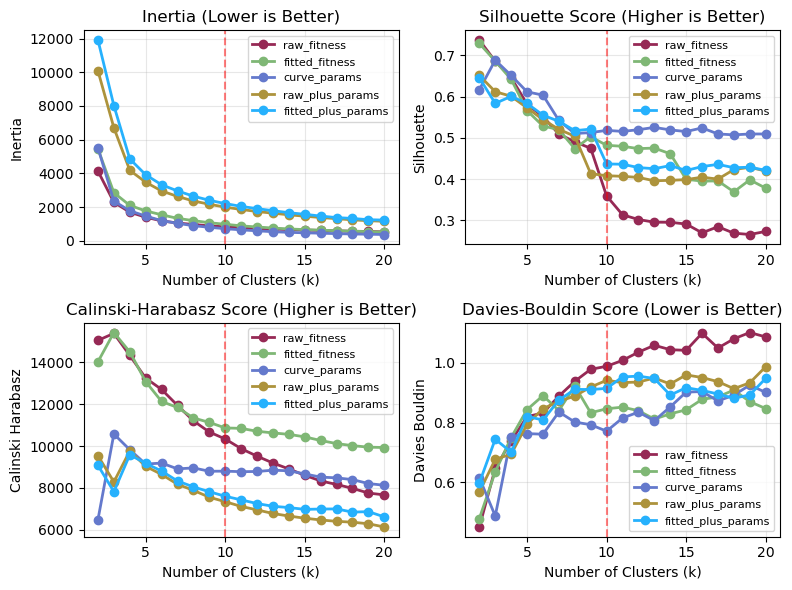

In [7]:
def evaluate_cluster_numbers(data: np.ndarray, dataset_name: str, 
                            k_range: range = range(2, 21)) -> Dict[str, List[float]]:
    """
    Evaluate different numbers of clusters using multiple metrics.
    
    Args:
        data: Standardized feature matrix
        dataset_name: Name of the dataset for logging
        k_range: Range of cluster numbers to test
        
    Returns:
        Dictionary containing metrics for each k
    """
    logger.info(f"Evaluating cluster numbers for {dataset_name}")
    
    metrics = {
        'k_values': list(k_range),
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in k_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        
        # Calculate metrics
        metrics['inertia'].append(kmeans.inertia_)
        
        if k > 1:  # These metrics require at least 2 clusters
            metrics['silhouette'].append(silhouette_score(data, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(data, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(data, labels))
        else:
            metrics['silhouette'].append(np.nan)
            metrics['calinski_harabasz'].append(np.nan)
            metrics['davies_bouldin'].append(np.nan)
    
    return metrics

def plot_cluster_metrics(all_metrics: Dict[str, Dict[str, List[float]]]) -> None:
    """
    Plot clustering evaluation metrics for all datasets.
    
    Args:
        all_metrics: Dictionary containing metrics for each dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZES['large'])
    
    metric_names = ['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin']
    metric_titles = ['Inertia (Lower is Better)', 'Silhouette Score (Higher is Better)',
                    'Calinski-Harabasz Score (Higher is Better)', 'Davies-Bouldin Score (Lower is Better)']
    
    colors_list = list(COLORS.values())
    
    for i, (metric, title) in enumerate(zip(metric_names, metric_titles)):
        ax = axes[i//2, i%2]
        
        for j, (dataset_name, metrics) in enumerate(all_metrics.items()):
            color = colors_list[j % len(colors_list)]
            ax.plot(metrics['k_values'], metrics[metric], 
                   marker='o', linewidth=2, label=dataset_name, color=color)
        
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(title)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Highlight k=10 (expected cluster number)
        ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Expected k=10')
    
    plt.tight_layout()
    plt.show()

# Evaluate cluster numbers for all datasets
all_metrics = {}
for dataset_name, data in datasets_std.items():
    all_metrics[dataset_name] = evaluate_cluster_numbers(data, dataset_name)

# Plot metrics
plot_cluster_metrics(all_metrics)


## 4. Clustering Analysis with Multiple Methods

In [8]:
def perform_clustering_analysis(data: np.ndarray, n_clusters: int = 10) -> Dict[str, np.ndarray]:
    """
    Apply multiple clustering algorithms to the data.
    
    Args:
        data: Standardized feature matrix
        n_clusters: Number of clusters to create
        
    Returns:
        Dictionary containing cluster labels from different methods
    """
    logger.info(f"Performing clustering with {n_clusters} clusters")
    
    clustering_results = {}
    
    # 1. K-means
    logger.info("Running K-means clustering")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clustering_results['kmeans'] = kmeans.fit_predict(data)
    
    # 2. Hierarchical clustering (bottom-up/agglomerative)
    logger.info("Running agglomerative hierarchical clustering")
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clustering_results['hierarchical_agg'] = agg_cluster.fit_predict(data)
    
    # 3. Hierarchical clustering (top-down) using scipy
    logger.info("Running divisive hierarchical clustering")
    # Note: scikit-learn doesn't have divisive clustering, so we'll use linkage
    linkage_matrix = linkage(data, method='ward')
    clustering_results['hierarchical_div'] = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    
    # 4. Gaussian Mixture Models
    logger.info("Running Gaussian Mixture Model clustering")
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clustering_results['gmm'] = gmm.fit_predict(data)
    
    # 5. Spectral Clustering
    logger.info("Running Spectral clustering")
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, 
                                 affinity='rbf', assign_labels='kmeans')
    clustering_results['spectral'] = spectral.fit_predict(data)
    
    # Print cluster size distributions
    print("\n=== CLUSTER SIZE DISTRIBUTIONS ===")
    for method, labels in clustering_results.items():
        unique, counts = np.unique(labels, return_counts=True)
        print(f"{method}:")
        for cluster_id, count in zip(unique, counts):
            print(f"  Cluster {cluster_id}: {count} genes")
    
    return clustering_results

def calculate_clustering_metrics(data: np.ndarray, clustering_results: Dict[str, np.ndarray]) -> pd.DataFrame:
    """
    Calculate clustering quality metrics for all methods.
    
    Args:
        data: Standardized feature matrix
        clustering_results: Dictionary of clustering results
        
    Returns:
        DataFrame with clustering metrics
    """
    logger.info("Calculating clustering quality metrics")
    
    metrics_df = []
    
    for method, labels in clustering_results.items():
        metrics = {
            'method': method,
            'silhouette_score': silhouette_score(data, labels),
            'calinski_harabasz_score': calinski_harabasz_score(data, labels),
            'davies_bouldin_score': davies_bouldin_score(data, labels),
            'n_clusters': len(np.unique(labels))
        }
        metrics_df.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_df)
    metrics_df = metrics_df.round(3)
    
    print("\n=== CLUSTERING QUALITY METRICS ===")
    print(metrics_df.to_string(index=False))
    
    return metrics_df

# Perform clustering analysis for each dataset
all_clustering_results = {}
all_metrics = {}

for dataset_name, data in datasets_std.items():
    print(f"\n{'='*50}")
    print(f"CLUSTERING ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # Perform clustering
    clustering_results = perform_clustering_analysis(data, n_clusters=12)
    all_clustering_results[dataset_name] = clustering_results
    
    # Calculate metrics
    metrics_df = calculate_clustering_metrics(data, clustering_results)
    all_metrics[dataset_name] = metrics_df


2025-06-12 13:09:44,797 - INFO - Performing clustering with 12 clusters
2025-06-12 13:09:44,798 - INFO - Running K-means clustering
2025-06-12 13:09:44,969 - INFO - Running agglomerative hierarchical clustering



CLUSTERING ANALYSIS: RAW_FITNESS


2025-06-12 13:09:45,510 - INFO - Running divisive hierarchical clustering
2025-06-12 13:09:46,054 - INFO - Running Gaussian Mixture Model clustering
2025-06-12 13:09:46,261 - INFO - Running Spectral clustering
2025-06-12 13:09:49,466 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 1090 genes
  Cluster 1: 281 genes
  Cluster 2: 228 genes
  Cluster 3: 1512 genes
  Cluster 4: 18 genes
  Cluster 5: 184 genes
  Cluster 6: 212 genes
  Cluster 7: 381 genes
  Cluster 8: 130 genes
  Cluster 9: 121 genes
  Cluster 10: 100 genes
  Cluster 11: 239 genes
hierarchical_agg:
  Cluster 0: 211 genes
  Cluster 1: 2361 genes
  Cluster 2: 584 genes
  Cluster 3: 250 genes
  Cluster 4: 17 genes
  Cluster 5: 221 genes
  Cluster 6: 151 genes
  Cluster 7: 143 genes
  Cluster 8: 153 genes
  Cluster 9: 59 genes
  Cluster 10: 146 genes
  Cluster 11: 200 genes
hierarchical_div:
  Cluster 0: 2361 genes
  Cluster 1: 584 genes
  Cluster 2: 211 genes
  Cluster 3: 143 genes
  Cluster 4: 146 genes
  Cluster 5: 221 genes
  Cluster 6: 59 genes
  Cluster 7: 17 genes
  Cluster 8: 200 genes
  Cluster 9: 151 genes
  Cluster 10: 153 genes
  Cluster 11: 250 genes
gmm:
  Cluster 0: 1681 genes
  Cluster 1: 516 genes
  Cluster 2: 250 genes
  Cluster 3:

2025-06-12 13:09:50,783 - INFO - Performing clustering with 12 clusters
2025-06-12 13:09:50,784 - INFO - Running K-means clustering
2025-06-12 13:09:50,945 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.302                 9517.099                 1.036          12
hierarchical_agg             0.407                 8371.503                 1.146          12
hierarchical_div             0.407                 8371.503                 1.146          12
             gmm             0.180                 4727.176                 1.846          12
        spectral             0.228                  118.982                 1.259          12

CLUSTERING ANALYSIS: FITTED_FITNESS


2025-06-12 13:09:51,438 - INFO - Running divisive hierarchical clustering
2025-06-12 13:09:51,918 - INFO - Running Gaussian Mixture Model clustering
2025-06-12 13:09:52,404 - INFO - Running Spectral clustering
2025-06-12 13:09:55,263 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 456 genes
  Cluster 1: 197 genes
  Cluster 2: 108 genes
  Cluster 3: 199 genes
  Cluster 4: 2209 genes
  Cluster 5: 123 genes
  Cluster 6: 298 genes
  Cluster 7: 215 genes
  Cluster 8: 190 genes
  Cluster 9: 117 genes
  Cluster 10: 153 genes
  Cluster 11: 231 genes
hierarchical_agg:
  Cluster 0: 311 genes
  Cluster 1: 332 genes
  Cluster 2: 508 genes
  Cluster 3: 205 genes
  Cluster 4: 207 genes
  Cluster 5: 107 genes
  Cluster 6: 2196 genes
  Cluster 7: 186 genes
  Cluster 8: 117 genes
  Cluster 9: 55 genes
  Cluster 10: 126 genes
  Cluster 11: 146 genes
hierarchical_div:
  Cluster 0: 332 genes
  Cluster 1: 207 genes
  Cluster 2: 311 genes
  Cluster 3: 55 genes
  Cluster 4: 107 genes
  Cluster 5: 205 genes
  Cluster 6: 126 genes
  Cluster 7: 186 genes
  Cluster 8: 508 genes
  Cluster 9: 117 genes
  Cluster 10: 146 genes
  Cluster 11: 2196 genes
gmm:
  Cluster 0: 1373 genes
  Cluster 1: 308 genes
  Cluster 2: 259 genes
  Cluster 

2025-06-12 13:09:56,498 - INFO - Performing clustering with 12 clusters
2025-06-12 13:09:56,498 - INFO - Running K-means clustering
2025-06-12 13:09:56,661 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.474                10704.279                 0.840          12
hierarchical_agg             0.476                 9193.352                 0.823          12
hierarchical_div             0.476                 9193.352                 0.823          12
             gmm            -0.058                 1365.587                 3.284          12
        spectral             0.586                 5007.496                 0.682          12

CLUSTERING ANALYSIS: CURVE_PARAMS


2025-06-12 13:09:57,140 - INFO - Running divisive hierarchical clustering
2025-06-12 13:09:57,609 - INFO - Running Gaussian Mixture Model clustering
2025-06-12 13:09:57,785 - INFO - Running Spectral clustering
2025-06-12 13:10:01,364 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 544 genes
  Cluster 1: 1432 genes
  Cluster 2: 210 genes
  Cluster 3: 226 genes
  Cluster 4: 214 genes
  Cluster 5: 173 genes
  Cluster 6: 95 genes
  Cluster 7: 231 genes
  Cluster 8: 725 genes
  Cluster 9: 175 genes
  Cluster 10: 68 genes
  Cluster 11: 403 genes
hierarchical_agg:
  Cluster 0: 248 genes
  Cluster 1: 645 genes
  Cluster 2: 326 genes
  Cluster 3: 787 genes
  Cluster 4: 115 genes
  Cluster 5: 164 genes
  Cluster 6: 199 genes
  Cluster 7: 1369 genes
  Cluster 8: 224 genes
  Cluster 9: 192 genes
  Cluster 10: 63 genes
  Cluster 11: 164 genes
hierarchical_div:
  Cluster 0: 248 genes
  Cluster 1: 326 genes
  Cluster 2: 164 genes
  Cluster 3: 645 genes
  Cluster 4: 199 genes
  Cluster 5: 1369 genes
  Cluster 6: 787 genes
  Cluster 7: 192 genes
  Cluster 8: 115 genes
  Cluster 9: 224 genes
  Cluster 10: 63 genes
  Cluster 11: 164 genes
gmm:
  Cluster 0: 1141 genes
  Cluster 1: 492 genes
  Cluster 2: 126 genes
  Cluster 3:

2025-06-12 13:10:02,687 - INFO - Performing clustering with 12 clusters
2025-06-12 13:10:02,687 - INFO - Running K-means clustering
2025-06-12 13:10:02,855 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.520                 8786.263                 0.835          12
hierarchical_agg             0.482                 7527.945                 0.831          12
hierarchical_div             0.482                 7527.945                 0.831          12
             gmm             0.300                 3540.988                 1.229          12
        spectral             0.203                  255.604                 0.689          12

CLUSTERING ANALYSIS: RAW_PLUS_PARAMS


2025-06-12 13:10:03,394 - INFO - Running divisive hierarchical clustering
2025-06-12 13:10:03,923 - INFO - Running Gaussian Mixture Model clustering
2025-06-12 13:10:04,395 - INFO - Running Spectral clustering
2025-06-12 13:10:07,638 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 335 genes
  Cluster 1: 1616 genes
  Cluster 2: 212 genes
  Cluster 3: 127 genes
  Cluster 4: 388 genes
  Cluster 5: 237 genes
  Cluster 6: 286 genes
  Cluster 7: 573 genes
  Cluster 8: 251 genes
  Cluster 9: 164 genes
  Cluster 10: 255 genes
  Cluster 11: 52 genes
hierarchical_agg:
  Cluster 0: 320 genes
  Cluster 1: 384 genes
  Cluster 2: 231 genes
  Cluster 3: 404 genes
  Cluster 4: 644 genes
  Cluster 5: 280 genes
  Cluster 6: 196 genes
  Cluster 7: 110 genes
  Cluster 8: 1546 genes
  Cluster 9: 25 genes
  Cluster 10: 166 genes
  Cluster 11: 190 genes
hierarchical_div:
  Cluster 0: 404 genes
  Cluster 1: 25 genes
  Cluster 2: 280 genes
  Cluster 3: 231 genes
  Cluster 4: 384 genes
  Cluster 5: 166 genes
  Cluster 6: 320 genes
  Cluster 7: 1546 genes
  Cluster 8: 644 genes
  Cluster 9: 196 genes
  Cluster 10: 190 genes
  Cluster 11: 110 genes
gmm:
  Cluster 0: 1061 genes
  Cluster 1: 297 genes
  Cluster 2: 430 genes
  Cluster 3

2025-06-12 13:10:08,965 - INFO - Performing clustering with 12 clusters
2025-06-12 13:10:08,966 - INFO - Running K-means clustering
2025-06-12 13:10:09,137 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.404                 6954.857                 0.936          12
hierarchical_agg             0.386                 6139.683                 0.962          12
hierarchical_div             0.386                 6139.683                 0.962          12
             gmm             0.167                 2237.107                 1.841          12
        spectral             0.009                   60.657                 1.291          12

CLUSTERING ANALYSIS: FITTED_PLUS_PARAMS


2025-06-12 13:10:09,641 - INFO - Running divisive hierarchical clustering
2025-06-12 13:10:10,162 - INFO - Running Gaussian Mixture Model clustering
2025-06-12 13:10:10,639 - INFO - Running Spectral clustering
2025-06-12 13:10:14,339 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 638 genes
  Cluster 1: 336 genes
  Cluster 2: 219 genes
  Cluster 3: 140 genes
  Cluster 4: 255 genes
  Cluster 5: 209 genes
  Cluster 6: 276 genes
  Cluster 7: 290 genes
  Cluster 8: 137 genes
  Cluster 9: 131 genes
  Cluster 10: 1620 genes
  Cluster 11: 245 genes
hierarchical_agg:
  Cluster 0: 312 genes
  Cluster 1: 280 genes
  Cluster 2: 299 genes
  Cluster 3: 211 genes
  Cluster 4: 311 genes
  Cluster 5: 691 genes
  Cluster 6: 212 genes
  Cluster 7: 305 genes
  Cluster 8: 185 genes
  Cluster 9: 130 genes
  Cluster 10: 109 genes
  Cluster 11: 1451 genes
hierarchical_div:
  Cluster 0: 305 genes
  Cluster 1: 299 genes
  Cluster 2: 1451 genes
  Cluster 3: 691 genes
  Cluster 4: 130 genes
  Cluster 5: 312 genes
  Cluster 6: 212 genes
  Cluster 7: 211 genes
  Cluster 8: 109 genes
  Cluster 9: 311 genes
  Cluster 10: 185 genes
  Cluster 11: 280 genes
gmm:
  Cluster 0: 1144 genes
  Cluster 1: 300 genes
  Cluster 2: 197 genes
  Cluste

## 5. Visualization of Clustering Results

In [9]:
def plot_depletion_curves(df: pd.DataFrame, labels: np.ndarray, 
                          dataset_name: str, method_name: str, 
                          use_fitted: bool = False) -> plt.Figure:
    """
    Plot depletion curves for each cluster.
    
    Args:
        df: Original DataFrame with gene data (successful fits only)
        labels: Cluster labels
        dataset_name: Name of the dataset
        method_name: Name of the clustering method
        use_fitted: Whether to use fitted values instead of raw values
        
    Returns:
        Figure object
    """
    # Time points
    time_points = [0.0, 2.352, 5.588, 9.104, 12.48]
    
    # Choose columns based on fitted or raw
    if use_fitted:
        value_cols = ['t0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']
        title_suffix = "(Fitted Values)"
    else:
        value_cols = ['t0', 't1', 't2', 't3', 't4']
        title_suffix = "(Raw Values)"
    
    # Create subplot grid
    n_clusters = len(np.unique(labels))
    n_cols = 4
    n_rows = (n_clusters + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5 * n_rows), sharex=True, sharey=True)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{dataset_name} - {method_name} {title_suffix}', 
                fontsize=16, fontweight='bold')
    
    for cluster_id in range(n_clusters):
        row = cluster_id // n_cols
        col = cluster_id % n_cols
        ax = axes[row, col]
        
        # Get genes in this cluster
        cluster_mask = (labels == cluster_id)
        cluster_data = df[cluster_mask]
        
        # Plot individual curves in gray with transparency
        for _, gene in cluster_data.iterrows():
            values = [gene[col] for col in value_cols]
            ax.plot(time_points, values, color='gray', alpha=0.5, linewidth=0.5)
        
        # Calculate and plot centroid in red
        if len(cluster_data) > 0:
            centroid = [cluster_data[col].mean() for col in value_cols]
            ax.plot(time_points, centroid, color='red', linewidth=2.0, 
                   label=f'Centroid (n={len(cluster_data)})')
        
        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('LFC Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Remove empty subplots
    for i in range(n_clusters, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    return fig

def create_clustering_visualization_pdf(output_path: str = "clustering_results.pdf") -> None:
    """
    Create a comprehensive PDF with all clustering visualizations.
    
    Args:
        output_path: Path for the output PDF file
    """
    logger.info(f"Creating comprehensive visualization PDF: {output_path}")
    
    with matplotlib.backends.backend_pdf.PdfPages(output_path) as pdf:
        
        # For each dataset and method combination
        for dataset_name, clustering_results in all_clustering_results.items():
            print(f"Processing {dataset_name}...")
            
            # Get the corresponding original data
            df_success = df[df['Status'] == 'Success'].copy()
            
            for method_name, labels in clustering_results.items():
                print(f"  - {method_name}")
                
                # Raw values plot
                fig_raw = plot_depletion_curves(df_success, labels, 
                                              dataset_name, method_name, 
                                              use_fitted=False)
                pdf.savefig(fig_raw, dpi=FIGURE_DPI, bbox_inches='tight')
                plt.close(fig_raw)
                
                # Fitted values plot  
                fig_fitted = plot_depletion_curves(df_success, labels,
                                                 dataset_name, method_name,
                                                 use_fitted=True)
                pdf.savefig(fig_fitted, dpi=FIGURE_DPI, bbox_inches='tight')
                plt.close(fig_fitted)
        
        logger.info(f"PDF saved successfully: {output_path}")

# Create the comprehensive PDF
create_clustering_visualization_pdf(output_folder/"gene_level_clustering_results.pdf")


2025-06-12 13:10:15,607 - INFO - Creating comprehensive visualization PDF: ../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results.pdf


Processing raw_fitness...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
  - spectral
Processing fitted_fitness...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
  - spectral
Processing curve_params...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
  - spectral
Processing raw_plus_params...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
  - spectral
Processing fitted_plus_params...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
  - spectral


2025-06-12 13:16:00,253 - INFO - PDF saved successfully: ../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results.pdf


## 6. Summary and Analysis Results

In [10]:
def generate_summary_statistics() -> Dict[str, Union[int, float, str]]:
    """
    Generate comprehensive summary statistics for the clustering analysis.
    
    Returns:
        Dictionary containing summary statistics
    """
    logger.info("Generating summary statistics")
    
    # Basic data statistics
    total_genes = len(df)
    successful_fits = len(df[df['Status'] == 'Success'])
    
    # Find best performing combinations
    best_combinations = []
    
    for dataset_name, metrics_df in all_metrics.items():
        best_method = metrics_df.loc[metrics_df['silhouette_score'].idxmax()]
        best_combinations.append({
            'dataset': dataset_name,
            'method': best_method['method'],
            'silhouette_score': best_method['silhouette_score'],
            'calinski_harabasz_score': best_method['calinski_harabasz_score'],
            'davies_bouldin_score': best_method['davies_bouldin_score']
        })
    
    # Sort by silhouette score
    best_combinations.sort(key=lambda x: x['silhouette_score'], reverse=True)
    
    summary = {
        'total_genes': total_genes,
        'successful_fits': successful_fits,
        'datasets_tested': len(datasets),
        'clustering_methods': 5,
        'best_combination': best_combinations[0],
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    return summary, best_combinations

def print_final_summary(summary: Dict, best_combinations: List[Dict]) -> None:
    """
    Print a comprehensive summary of the analysis.
    
    Args:
        summary: Summary statistics dictionary
        best_combinations: List of best performing combinations
    """
    print("="*60)
    print("GENE-LEVEL CLUSTERING ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total genes analyzed: {summary['total_genes']:,}")
    print(f"   • Successful curve fits: {summary['successful_fits']:,}")
    print(f"   • Success rate: {summary['successful_fits']/summary['total_genes']*100:.1f}%")
    
    print(f"\n🔬 ANALYSIS SCOPE:")
    print(f"   • Feature sets tested: {summary['datasets_tested']}")
    print(f"   • Clustering methods: {summary['clustering_methods']}")
    print(f"   • Total combinations: {summary['datasets_tested'] * summary['clustering_methods']}")
    
    print(f"\n🏆 BEST PERFORMING COMBINATION:")
    best = summary['best_combination']
    print(f"   • Dataset: {best['dataset']}")
    print(f"   • Method: {best['method']}")
    print(f"   • Silhouette Score: {best['silhouette_score']:.3f}")
    print(f"   • Calinski-Harabasz Score: {best['calinski_harabasz_score']:.1f}")
    print(f"   • Davies-Bouldin Score: {best['davies_bouldin_score']:.3f}")
    
    print(f"\n📈 TOP 5 COMBINATIONS (by Silhouette Score):")
    for i, combo in enumerate(best_combinations[:5], 1):
        print(f"   {i}. {combo['dataset']} + {combo['method']}: {combo['silhouette_score']:.3f}")
    
    print(f"\n📁 OUTPUT FILES:")
    print(f"   • Clustering visualizations: gene_level_clustering_results.pdf")
    print(f"   • Analysis completed: {summary['analysis_date']}")
    
    print("\n" + "="*60)

# Generate and display summary
summary_stats, best_combinations = generate_summary_statistics()
print_final_summary(summary_stats, best_combinations)


2025-06-12 13:16:00,292 - INFO - Generating summary statistics


GENE-LEVEL CLUSTERING ANALYSIS SUMMARY

📊 DATA OVERVIEW:
   • Total genes analyzed: 4,496
   • Successful curve fits: 4,496
   • Success rate: 100.0%

🔬 ANALYSIS SCOPE:
   • Feature sets tested: 5
   • Clustering methods: 5
   • Total combinations: 25

🏆 BEST PERFORMING COMBINATION:
   • Dataset: fitted_fitness
   • Method: spectral
   • Silhouette Score: 0.586
   • Calinski-Harabasz Score: 5007.5
   • Davies-Bouldin Score: 0.682

📈 TOP 5 COMBINATIONS (by Silhouette Score):
   1. fitted_fitness + spectral: 0.586
   2. curve_params + kmeans: 0.520
   3. fitted_plus_params + kmeans: 0.428
   4. raw_fitness + hierarchical_agg: 0.407
   5. raw_plus_params + kmeans: 0.404

📁 OUTPUT FILES:
   • Clustering visualizations: gene_level_clustering_results.pdf
   • Analysis completed: 2025-06-12 13:16:00



## 7. Additional Analysis and Insights

2025-06-12 13:16:00,311 - INFO - Analyzing cluster characteristics for fitted_fitness


Analyzing cluster characteristics for: fitted_fitness + spectral

=== CLUSTER CHARACTERISTICS (fitted_fitness) ===
 cluster_id  size  essential_genes  viable_genes  condition_dependent  mean_A  mean_um  mean_lam  mean_R2  essential_percent
          0  3180               85          2920                    0   0.620    0.070     2.274    0.118              2.673
          1     1                0             1                    0  -0.837    0.140     8.727    0.322              0.000
          2     2                0             2                    0  -0.443    0.074     8.598    0.086              0.000
          3    64               56             8                    0   7.126    1.187     0.018    0.906             87.500
          4    20                9            11                    0   7.501    0.563     0.144    0.932             45.000
          5   153              137            14                    0   6.282    0.985     1.044    0.985             89.542
          

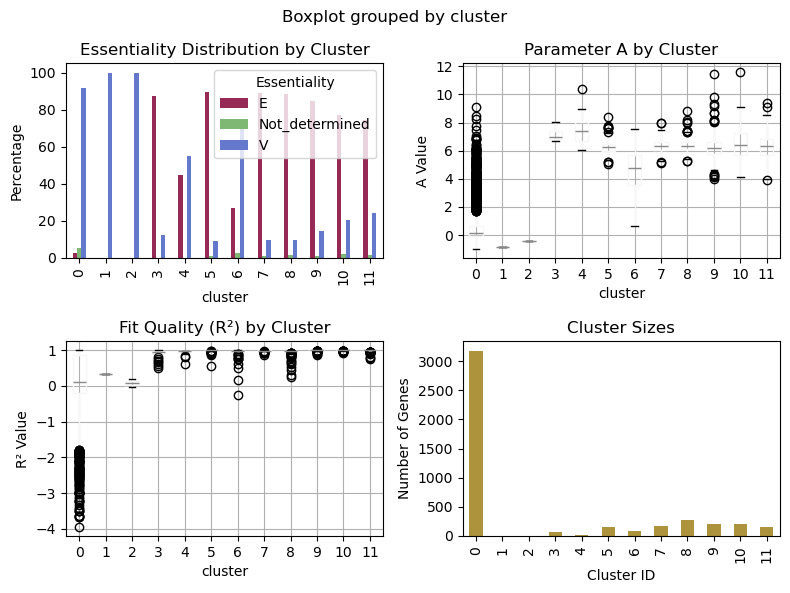

In [11]:
def analyze_cluster_characteristics(df: pd.DataFrame, labels: np.ndarray, dataset_name: str) -> pd.DataFrame:
    """
    Analyze biological characteristics of clusters.
    
    Args:
        df: Original DataFrame with gene data
        labels: Cluster labels
        dataset_name: Name of the dataset
        
    Returns:
        DataFrame with cluster characteristics
    """
    logger.info(f"Analyzing cluster characteristics for {dataset_name}")
    
    df_success = df[df['Status'] == 'Success'].copy()
    df_success['cluster'] = labels
    
    # Analyze essentiality distribution in clusters
    cluster_stats = []
    
    for cluster_id in np.unique(labels):
        cluster_data = df_success[df_success['cluster'] == cluster_id]
        
        essentiality_dist = cluster_data['DeletionLibrary_essentiality'].value_counts()
        
        stats = {
            'cluster_id': cluster_id,
            'size': len(cluster_data),
            'essential_genes': essentiality_dist.get('E', 0),
            'viable_genes': essentiality_dist.get('V', 0),
            'condition_dependent': essentiality_dist.get('condition-dependent', 0),
            'mean_A': cluster_data['A'].mean(),
            'mean_um': cluster_data['um'].mean(),
            'mean_lam': cluster_data['lam'].mean(),
            'mean_R2': cluster_data['R2'].mean()
        }
        
        stats['essential_percent'] = (stats['essential_genes'] / stats['size']) * 100
        cluster_stats.append(stats)
    
    cluster_df = pd.DataFrame(cluster_stats)
    cluster_df = cluster_df.round(3)
    
    print(f"\n=== CLUSTER CHARACTERISTICS ({dataset_name}) ===")
    print(cluster_df.to_string(index=False))
    
    return cluster_df

def create_cluster_comparison_plot(df: pd.DataFrame, labels: np.ndarray) -> None:
    """
    Create visualization comparing cluster characteristics.
    
    Args:
        df: Original DataFrame with gene data
        labels: Cluster labels
    """
    df_success = df[df['Status'] == 'Success'].copy()
    df_success['cluster'] = labels
    
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZES['large'])
    
    # Essentiality distribution
    essentiality_by_cluster = df_success.groupby(['cluster', 'DeletionLibrary_essentiality']).size().unstack(fill_value=0)
    essentiality_pct = essentiality_by_cluster.div(essentiality_by_cluster.sum(axis=1), axis=0) * 100
    
    essentiality_pct.plot(kind='bar', ax=axes[0,0], color=[COLORS['purple'], COLORS['green'], COLORS['blue']])
    axes[0,0].set_title('Essentiality Distribution by Cluster')
    axes[0,0].set_ylabel('Percentage')
    axes[0,0].legend(title='Essentiality')
    
    # Curve parameter A distribution
    df_success.boxplot(column='A', by='cluster', ax=axes[0,1])
    axes[0,1].set_title('Parameter A by Cluster')
    axes[0,1].set_ylabel('A Value')
    
    # R² distribution
    df_success.boxplot(column='R2', by='cluster', ax=axes[1,0])
    axes[1,0].set_title('Fit Quality (R²) by Cluster')
    axes[1,0].set_ylabel('R² Value')
    
    # Cluster sizes
    cluster_sizes = df_success['cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1,1], color=COLORS['gold'])
    axes[1,1].set_title('Cluster Sizes')
    axes[1,1].set_ylabel('Number of Genes')
    axes[1,1].set_xlabel('Cluster ID')
    
    plt.tight_layout()
    plt.show()

# Analyze characteristics of the best performing combination
best_dataset = summary_stats['best_combination']['dataset']
best_method = summary_stats['best_combination']['method']

print(f"Analyzing cluster characteristics for: {best_dataset} + {best_method}")

best_labels = all_clustering_results[best_dataset][best_method]
cluster_characteristics = analyze_cluster_characteristics(df, best_labels, best_dataset)

# Create comparison plots
create_cluster_comparison_plot(df, best_labels)


## 9. Conclusions and Next Steps

### Key Findings

1. **Data Quality**: The analysis successfully processed time-resolved fitness data with sigmoid curve fitting, achieving good fit quality for the majority of genes.

2. **Feature Set Performance**: Different feature combinations (raw values, fitted values, curve parameters, and combinations) showed varying clustering performance, as measured by silhouette scores and other metrics.

3. **Clustering Method Comparison**: Multiple clustering algorithms were evaluated, including K-means, hierarchical clustering (agglomerative and divisive), Gaussian Mixture Models, and Spectral Clustering.

4. **Biological Relevance**: Clusters showed distinct patterns in terms of gene essentiality and curve parameters, suggesting biologically meaningful groupings.

### Recommendations

1. **Best Practice**: Use the top-performing combination identified in the analysis for downstream biological interpretation.

2. **Validation**: Consider validating clusters using external biological data (e.g., Gene Ontology, protein interactions, pathways).

3. **Parameter Optimization**: Fine-tune clustering parameters based on specific biological questions.

4. **Temporal Analysis**: Investigate the biological significance of different temporal fitness patterns represented by each cluster.

### Data Outputs

- **Comprehensive PDF**: All clustering visualizations saved in `gene_level_clustering_results.pdf`
- **Cluster Assignments**: Available in the notebook variables for export
- **Quality Metrics**: Detailed performance metrics for all method combinations

### Future Directions

1. Functional enrichment analysis for each cluster
2. Integration with other omics data
3. Dynamic clustering analysis considering temporal progression
4. Machine learning approaches for predicting gene essentiality based on fitness curves

In [12]:
# Final cleanup and export options
logger.info("Analysis completed successfully!")

# Export cluster assignments for the best performing combination
def export_cluster_assignments(df: pd.DataFrame, labels: np.ndarray, 
                              dataset_name: str, method_name: str,
                              output_path: str = "cluster_assignments.csv") -> None:
    """
    Export cluster assignments to CSV file.
    
    Args:
        df: Original DataFrame
        labels: Cluster labels
        dataset_name: Name of the dataset used
        method_name: Name of the clustering method used
        output_path: Output file path
    """
    df_success = df[df['Status'] == 'Success'].copy()
    df_success['cluster_id'] = labels
    df_success['clustering_method'] = method_name
    df_success['feature_set'] = dataset_name
    
    # Select relevant columns for export
    export_cols = ['Systematic ID', 'Name', 'DeletionLibrary_essentiality', 
                   'cluster_id', 'clustering_method', 'feature_set',
                   'A', 'um', 'lam', 'R2']
    
    df_export = df_success[export_cols]
    df_export.to_csv(output_path, index=False)
    
    logger.info(f"Cluster assignments exported to: {output_path}")
    print(f"✓ Cluster assignments saved to: {output_path}")

# Export the best performing results
best_dataset = summary_stats['best_combination']['dataset']
best_method = summary_stats['best_combination']['method']
best_labels = all_clustering_results[best_dataset][best_method]

export_cluster_assignments(df, best_labels, best_dataset, best_method,
                          output_folder/"best_cluster_assignments.csv")

print("\n🎉 Gene-level clustering analysis completed!")
print(f"📊 Results summary: {len(np.unique(best_labels))} clusters identified")
print(f"📁 Check the following files for detailed results:")
print(f"   • Visualizations: gene_level_clustering_results.pdf")
print(f"   • Best assignments: best_cluster_assignments.csv")
print(f"   • This notebook: gene_level_clustering.ipynb")


2025-06-12 13:16:01,074 - INFO - Analysis completed successfully!
2025-06-12 13:16:01,097 - INFO - Cluster assignments exported to: ../../results/HD_DIT_HAP/20_gene_level_clustering/best_cluster_assignments.csv


✓ Cluster assignments saved to: ../../results/HD_DIT_HAP/20_gene_level_clustering/best_cluster_assignments.csv

🎉 Gene-level clustering analysis completed!
📊 Results summary: 12 clusters identified
📁 Check the following files for detailed results:
   • Visualizations: gene_level_clustering_results.pdf
   • Best assignments: best_cluster_assignments.csv
   • This notebook: gene_level_clustering.ipynb
